In [2]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from scipy.special import softmax
from plots import plot_learning_curves, plot_confusion_matrix
from utils import train_RNN, evaluate, VisitSequenceWithLabelDataset, visit_collate_fn

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import average_precision_score as pr_auc
from model import RNN, Content, RecognitionNetwork
from create_dataset import get_seqs_labels, calculate_num_features

%load_ext autoreload
%autoreload 2

# Get Data

In [3]:
file = open('data/train.pkl', 'rb')
train_df = pickle.load(file)
file = open('data/valid.pkl', 'rb')
valid_df = pickle.load(file)
file = open('data/test.pkl', 'rb')
test_df = pickle.load(file)

# Create sequence and labels

In [4]:
train_seqs, train_labels = get_seqs_labels(train_df)
val_seqs, val_labels = get_seqs_labels(valid_df)
test_seqs, test_labels = get_seqs_labels(test_df)
num_features = calculate_num_features(train_seqs)

# Initialize model parameters

In [5]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0
output_path = 'model_object/'

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# create DataLoader

In [6]:
train_dataset = VisitSequenceWithLabelDataset(train_seqs, train_labels, num_features)
valid_dataset = VisitSequenceWithLabelDataset(val_seqs, val_labels, num_features)
test_dataset = VisitSequenceWithLabelDataset(test_seqs, test_labels, num_features)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)

# Model training with 3 epochs

/Users/jasonzeng/Documents/OMSCS/cse6250/project/CSE6250_Project/utils.py:204: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  seqs_tensor = torch.FloatTensor(seqs)


Epoch: [0][0/167]	Time 3.117 (3.117)	Data 0.507 (0.507)	Loss 0.7006 (0.7006)	Accuracy 39.062 (39.062)
Epoch: [0][10/167]	Time 2.294 (2.968)	Data 0.468 (0.520)	Loss 0.7019 (0.6953)	Accuracy 23.438 (48.864)
Epoch: [0][20/167]	Time 2.061 (2.896)	Data 0.329 (0.512)	Loss 0.7409 (0.6974)	Accuracy 34.375 (49.702)
Epoch: [0][30/167]	Time 4.200 (2.953)	Data 0.648 (0.529)	Loss 0.5997 (0.6974)	Accuracy 81.250 (50.353)
Epoch: [0][40/167]	Time 2.573 (2.785)	Data 0.392 (0.504)	Loss 0.7488 (0.6973)	Accuracy 32.812 (51.067)
Epoch: [0][50/167]	Time 2.898 (2.770)	Data 0.431 (0.500)	Loss 0.7430 (0.7094)	Accuracy 23.438 (47.825)
Epoch: [0][60/167]	Time 2.734 (2.768)	Data 0.414 (0.499)	Loss 0.6992 (0.7077)	Accuracy 29.688 (46.670)
Epoch: [0][70/167]	Time 2.325 (2.781)	Data 0.485 (0.499)	Loss 0.6952 (0.7054)	Accuracy 32.812 (46.985)
Epoch: [0][80/167]	Time 3.491 (2.816)	Data 0.607 (0.503)	Loss 0.6869 (0.7046)	Accuracy 73.438 (46.586)
Epoch: [0][90/167]	Time 2.178 (2.775)	Data 0.423 (0.500)	Loss 0.7237 (0.70

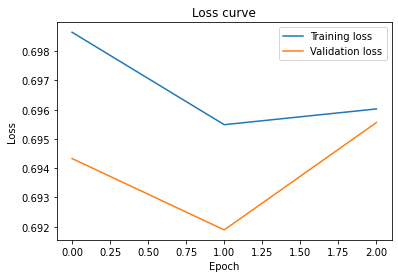

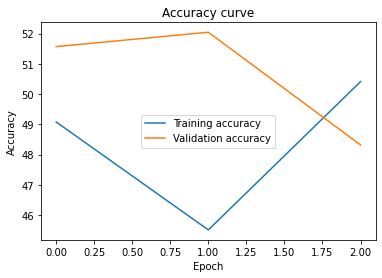

In [7]:
hidden_size = 200
num_layers = 2
num_classes= 2
embedding_dim = 100
num_topic = 50
bidirectional=True

model = Content(num_features, hidden_size, num_layers, num_classes, embedding_dim, num_topic, bidirectional)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies, train_aucs = [], [], []
valid_losses, valid_accuracies, valid_aucs = [], [], []
for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy, train_auc = train_RNN(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss, valid_accuracy, valid_auc, valid_results = evaluate(model, device, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)

    is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
    if is_best:
        
        best_val_acc = valid_accuracy
        torch.save(model, os.path.join(output_path, "content_3_epochs.pth"), _use_new_zipfile_serialization=False)
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, 'figures', 'content_3_epochs')

In [8]:
train_accuracies

[49.07912046392706, 45.50836309107863, 50.41345611583736]

In [9]:
train_aucs

[0.4990935214385501, 0.5000550948820008, 0.50050963321375]

In [10]:
valid_accuracies, valid_aucs

([51.57163742690059, 52.046783625730995, 48.3187134502924],
 [0.4994683678894205, 0.5004873294346979, 0.5018746138783073])

In [11]:
best_model = torch.load(os.path.join(output_path, "content_3_epochs.pth"))

test_loss, test_accuracy, test_auc, test_results = evaluate(best_model, device, test_loader, criterion)

Test: [0/42]	Time 0.849 (0.849)	Loss 0.6829 (0.6829)	Accuracy 73.438 (73.438)
Test: [10/42]	Time 0.545 (0.755)	Loss 0.6823 (0.6940)	Accuracy 81.250 (43.324)
Test: [20/42]	Time 1.086 (0.816)	Loss 0.6836 (0.6944)	Accuracy 70.312 (44.048)
Test: [30/42]	Time 0.832 (0.807)	Loss 0.7042 (0.6957)	Accuracy 31.250 (43.498)
Test: [40/42]	Time 0.796 (0.814)	Loss 0.7060 (0.6955)	Accuracy 29.688 (45.465)


In [12]:
test_accuracy, test_auc

(45.07518796132023, 0.5021421589619697)

# Model training with 10 epochs

In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 64
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0
output_path = 'model_object/'

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Epoch: [0][0/167]	Time 3.106 (3.106)	Data 0.519 (0.519)	Loss 0.7006 (0.7006)	Accuracy 39.062 (39.062)
Epoch: [0][10/167]	Time 2.289 (3.002)	Data 0.511 (0.550)	Loss 0.7019 (0.6953)	Accuracy 23.438 (48.864)
Epoch: [0][20/167]	Time 1.874 (2.902)	Data 0.323 (0.540)	Loss 0.7409 (0.6974)	Accuracy 34.375 (49.702)
Epoch: [0][30/167]	Time 4.110 (2.960)	Data 0.681 (0.560)	Loss 0.5997 (0.6974)	Accuracy 81.250 (50.353)
Epoch: [0][40/167]	Time 2.746 (2.798)	Data 0.479 (0.538)	Loss 0.7488 (0.6973)	Accuracy 32.812 (51.067)
Epoch: [0][50/167]	Time 2.923 (2.791)	Data 0.476 (0.533)	Loss 0.7430 (0.7094)	Accuracy 23.438 (47.825)
Epoch: [0][60/167]	Time 2.935 (2.846)	Data 0.466 (0.539)	Loss 0.6992 (0.7077)	Accuracy 29.688 (46.670)
Epoch: [0][70/167]	Time 2.587 (2.875)	Data 0.527 (0.539)	Loss 0.6952 (0.7054)	Accuracy 32.812 (46.985)
Epoch: [0][80/167]	Time 3.762 (2.922)	Data 0.715 (0.546)	Loss 0.6869 (0.7046)	Accuracy 73.438 (46.586)
Epoch: [0][90/167]	Time 2.238 (2.883)	Data 0.477 (0.544)	Loss 0.7237 (0.70

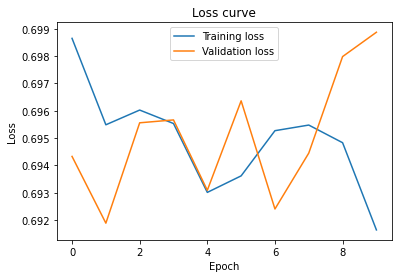

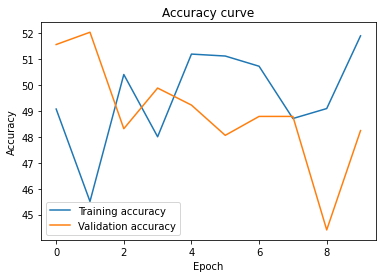

In [14]:
hidden_size = 200
num_layers = 2
num_classes= 2
embedding_dim = 100
num_topic = 50
bidirectional=True

model = Content(num_features, hidden_size, num_layers, num_classes, embedding_dim, num_topic, bidirectional)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies, train_aucs = [], [], []
valid_losses, valid_accuracies, valid_aucs = [], [], []
for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy, train_auc = train_RNN(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss, valid_accuracy, valid_auc, valid_results = evaluate(model, device, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)

    is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
    if is_best:
        
        best_val_acc = valid_accuracy
        torch.save(model, os.path.join(output_path, "content_10_epochs.pth"), _use_new_zipfile_serialization=False)
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, 'figures', 'content_10_epochs')

In [15]:
train_accuracies

[49.07912046392706,
 45.50836309107863,
 50.41345611583736,
 48.007893253864815,
 51.202781436363125,
 51.12760759040705,
 50.73294493444565,
 48.71264799921344,
 49.09791392380303,
 51.90753617884409]

In [16]:
train_aucs

[0.4990935214385501,
 0.5000550948820008,
 0.50050963321375,
 0.5003226831229522,
 0.501990900563798,
 0.4973433475490191,
 0.49892984093605186,
 0.5012368015039785,
 0.5007280602551539,
 0.49945683685995357]

In [17]:
valid_accuracies, valid_aucs

([51.57163742690059,
  52.046783625730995,
  48.3187134502924,
  49.89035087719298,
  49.23245614035088,
  48.0628655193842,
  48.79385964912281,
  48.79385964912281,
  44.4078947368421,
  48.24561403508772],
 [0.4994683678894205,
  0.5004873294346979,
  0.5018746138783073,
  0.5015335541651331,
  0.5000531632110579,
  0.5055612961523643,
  0.5024212578229199,
  0.501412400481007,
  0.5005915906192915,
  0.5])

In [18]:
best_model = torch.load(os.path.join(output_path, "content_10_epochs.pth"))

test_loss, test_accuracy, test_auc, test_results = evaluate(best_model, device, test_loader, criterion)

Test: [0/42]	Time 0.699 (0.699)	Loss 0.6941 (0.6941)	Accuracy 43.750 (43.750)
Test: [10/42]	Time 0.583 (0.742)	Loss 0.6887 (0.6931)	Accuracy 62.500 (49.290)
Test: [20/42]	Time 0.906 (0.799)	Loss 0.7054 (0.6944)	Accuracy 28.125 (44.568)
Test: [30/42]	Time 0.633 (0.820)	Loss 0.7090 (0.6947)	Accuracy 29.688 (46.522)
Test: [40/42]	Time 0.884 (0.809)	Loss 0.6996 (0.6947)	Accuracy 34.375 (47.523)


In [19]:
test_accuracy, test_auc

(47.70676691155685, 0.5003041574980801)